In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
sns.set()

Загрузка данных первого сета.

In [203]:
abalone = pd.read_csv('abalone.data',names=["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"])
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [204]:
abalone.head(100)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
95,M,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,14
96,M,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,9
97,M,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,8
98,M,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,7


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [205]:
abalone.count()

Sex               4177
Length            4177
Diameter          4177
Height            4177
Whole weight      4177
Shucked weight    4177
Viscera weight    4177
Shell weight      4177
Rings             4177
dtype: int64

В процентном соотношении.

In [206]:
for col in abalone.columns:
    pct_missing = np.mean(abalone[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {abalone[col].min()}     max:{abalone[col].max()}')

Sex - 0.0     min: F     max:M
Length - 0.0     min: 0.075     max:0.815
Diameter - 0.0     min: 0.055     max:0.65
Height - 0.0     min: 0.0     max:1.13
Whole weight - 0.0     min: 0.002     max:2.8255
Shucked weight - 0.0     min: 0.001     max:1.488
Viscera weight - 0.0     min: 0.0005     max:0.76
Shell weight - 0.0     min: 0.0015     max:1.005
Rings - 0.0     min: 1     max:29


In [207]:
abalone.drop(columns=["Shucked weight","Viscera weight","Shell weight","Length"], inplace=True)

In [208]:
abalone["amount"] = abalone["Diameter"]*abalone["Height"]*abalone["Whole weight"]
abalone.drop(columns=["Diameter","Height","Whole weight"], inplace=True)

Пропущенных значений нет, как и заявлялось в описании. Странность есть в минимальном значении столбца "chlorides", исправим:

In [209]:
abalone.describe()

,Rings,amount
count,4177.000000,4177.000000
mean,9.933684,0.062847
std,3.224169,0.058284
min,1.000000,0.000000
25%,8.000000,0.017575
50%,9.000000,0.048399
75%,11.000000,0.091532
max,29.000000,0.643055


Из таблицы резко выбиваются значения "free sulfur dioxide":289 и "total sulfur dioxide": 400. Проверим не ошибочные ли это данные.

<AxesSubplot: xlabel='Sex', ylabel='amount'>

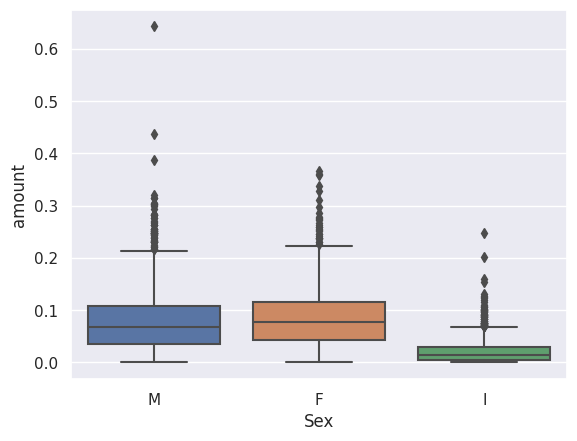

In [210]:
sns.boxplot(x="Sex", y="amount", data=abalone)

In [211]:
abalone['Sex']= np.where(abalone["Sex"]!="I","MF","I")

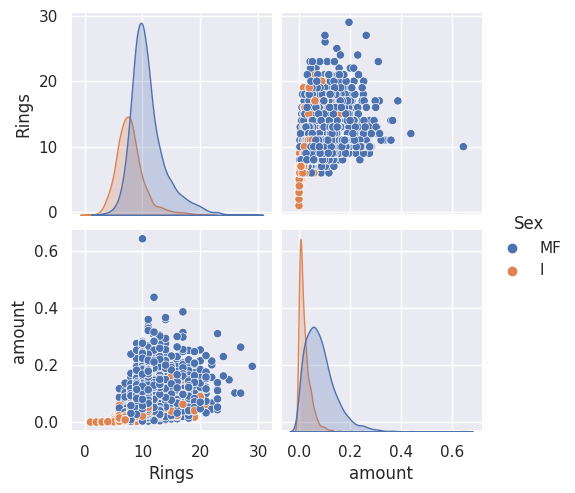

In [212]:
sns.pairplot(abalone,hue="Sex");

In [213]:
encoder = LabelEncoder()
target = encoder.fit_transform(abalone["Sex"])
abalone.drop(columns=["Sex"],inplace=True)

In [214]:
datasets= {"train":{},"validation":{},"test":{}}
datasets["train"]["data"], test_val_data, datasets["train"]["target"], test_val_target = train_test_split(abalone, target, train_size=0.718218817334, shuffle=True)
print(datasets["train"]["data"].shape)
datasets["test"]["data"], datasets["validation"]["data"], datasets["test"]["target"], datasets["validation"]["target"] = train_test_split(test_val_data, test_val_target, test_size=0.849617672047, shuffle=True)
print(datasets["validation"]["data"].shape)

(3000, 2)
(1000, 2)


In [215]:
nei = KNeighborsClassifier()
nei.fit(datasets["train"]["data"],datasets["train"]["target"])

KNeighborsClassifier()

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [221]:
predictions = nei.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
cv_sgd = cross_validate(nei,datasets["train"]["data"],datasets["train"]["target"])
print("RMSE for sgd: {}".format(np.sqrt(mse)))

RMSE for sgd: 0.4219004621945797


Как видно лучше всего справляется модель Lasso, её и возьмём за основу.

In [217]:
lasso = Lasso(max_iter=5000,selection="cyclic",alpha=3,positive=True)
lasso.fit(datasets["train"]["data"],datasets["train"]["target"])
predictions = lasso.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.4680741869025085


Посмотрим какая ошибка будет на тестовой части данных.

In [218]:
predictions = lasso.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.49752254583668787


(Если я не ошибаюсь) Процент правильности предсказания лежит где-то между 85-90%, нас это удовлетворяет.

Попробуем прогнать нашу же модель Lasso через подборку лучших гиперпараметров.

In [219]:
parameters = {"alpha":[0.1,0.2,0.3,0.4],"max_iter":[1000,2000,3000,4000,5000],"warm_start":[True,False],"positive":[True,False],"selection":["cyclic","random"]}
clf = GridSearchCV(Lasso(), parameters)
clf.fit(datasets["train"]["data"],datasets["train"]["target"])

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4],
                         'max_iter': [1000, 2000, 3000, 4000, 5000],
                         'positive': [True, False],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]})

In [220]:
predictions = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.4437712986365013


Для меня лично удивительно что показатели не изменились, но значит или я что-то сделал не так, или модель мало восприимчива к имениям параметров. Точность так же осталась в пределах 85-90% что довольно высокий показатель. Мне кажется что не последнюю роль в таких результатах сыграла прямая корреляция столбца alcohol напрямую на таргет, из-за чего модель может предположить только по этому параметру оценку, и уже из двух соседних оценок выбрать на основе всех остальных столбцов.